#### Forecasting: Imports and Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers

import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ts_utils
import ts_plot_utils

mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

2023-03-24 14:34:48.567768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read the data
df, df_scaled_trn, df_scaled_tst, scaler = ts_utils.load_file()
print("Training Data:")
display(df_scaled_trn)

input_slice  = slice(0, len(df_scaled_trn.columns) )
label_slice  = slice(0,3)
window_len   = 24
ouput_len    = 1
batch_size   = 64

inp_feat_len    = input_slice.stop - (input_slice.start or 0)
ouput_feat_len  = label_slice.stop - (label_slice.start or 0)

ds_trn        = tf.data.Dataset.from_tensor_slices(df_scaled_trn[df_scaled_trn.columns[input_slice]])
ds_tst        = tf.data.Dataset.from_tensor_slices(df_scaled_tst[df_scaled_trn.columns[input_slice]])
window_trn    = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size,)
window_tst    = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size )
window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000  )
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000  )


Training Data:


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Day sin,Day cos,Year sin,Year cos
0,0.918199,-2.018473,-2.075600,-1.951683,1.102658,-1.315794,-1.483534,-0.788226,-1.485852,-1.488569,2.246640,-1.257984,-1.252731,0.214456,0.366058,1.366366,-0.049590,1.401955
1,0.932570,-2.116803,-2.174215,-2.096616,1.029922,-1.343873,-1.541361,-0.783947,-1.542786,-1.545690,2.356037,-1.232044,-1.252731,0.186889,0.707152,1.225091,-0.048581,1.401945
2,0.958917,-2.108510,-2.168345,-2.080512,1.048106,-1.342536,-1.534133,-0.786086,-1.535194,-1.538550,2.354292,-1.277439,-1.252731,-0.078439,1.000057,1.000355,-0.047571,1.401933
3,0.976881,-2.136943,-2.197695,-2.133215,0.993555,-1.350558,-1.553409,-0.779667,-1.554173,-1.559970,2.389927,-1.329318,-1.359684,0.757747,1.224811,0.707473,-0.046562,1.401921
4,1.033168,-2.205656,-2.270482,-2.225446,0.969309,-1.367941,-1.587141,-0.779667,-1.588333,-1.593290,2.479139,-1.134770,-1.145779,-0.195597,1.366097,0.366405,-0.045552,1.401908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56067,0.372099,0.968172,0.930989,0.772772,-0.861203,0.859638,0.687395,0.765285,0.677648,0.677237,-0.821697,0.551316,0.445669,-1.621823,-0.707116,-1.224304,0.811018,-1.136631
56068,0.321800,1.040439,1.007298,0.693717,-1.132749,0.962593,0.583788,1.024204,0.571371,0.574897,-0.891223,-0.823493,-0.546847,-0.857195,-1.000021,-0.999567,0.810227,-1.137265
56069,0.254736,1.233546,1.204528,0.661510,-1.517642,1.255414,0.542827,1.529202,0.533415,0.534437,-1.069895,-0.992101,-0.940431,-0.356402,-1.224775,-0.706686,0.809435,-1.137897
56070,0.206832,1.189712,1.164613,0.657118,-1.452180,1.187223,0.535599,1.424350,0.529619,0.529677,-1.044478,-0.881857,-0.940431,0.264994,-1.366061,-0.365618,0.808642,-1.138529


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-24 14:34:59.289133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
%%script echo Skipping - Testing Window -comment this line to test

# Check if your window logic is correctly working
# Note it will print only the first item in the batch
#
i =0
for w in window_trn.take(i+1):
    break;

print(f"Sample a window at index {i} verify the window is working:\n")
print(f"{w[0].numpy().shape}\n{w[0][0].numpy()}\n=>:{w[1].numpy().shape}\n{w[1][0].numpy()} \n")


Skipping - Testing Window -comment this line to test


In [4]:
%%script echo Skipping - Inverse transform comment this line to test

display(df_scaled_trn[:4])
display(df[df.columns[1:]][:4])
pd.DataFrame(scaler.inverse_transform(df_scaled_trn[:4].values), columns=df_scaled_trn.columns)

Skipping - Inverse transform comment this line to test


In [5]:
def compile_fit(model, window_trn, window_tst= None, opt=None, patience=3, epochs=1, **kwargs):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights = True)

    loss = tf.keras.losses.MeanSquaredError()
    opt  = opt or tf.keras.optimizers.Adam()
    mets = [tf.keras.metrics.MeanAbsoluteError()]

    ##=> Other options you can try
    #learning_rate = 1e-6
    #opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    #opt = tf.keras.optimizers.SGD()
    #loss=tf.keras.losses.Huber()

    model.compile(loss= loss, optimizer= opt, metrics=mets)

    history = []
    if (window_trn is not None):
        history = model.fit(window_trn, epochs=epochs, validation_data=window_tst, 
                                workers=4, use_multiprocessing=True, callbacks=[early_stop], **kwargs)

    return history

# This commonLayer, a layer that is common to all models

def getCommonLayer(ouput_len, ouput_feat_len):
    op_len = ouput_len * ouput_feat_len;
    commonLayer = [
        # Shape => [batch, 1, out_len * #features]
        tf.keras.layers.Dense( op_len, kernel_initializer=tf.initializers.zeros()),
        
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([ouput_len, ouput_feat_len])
    ]
    return commonLayer

performance = {}
models = []

In [6]:
# LSTM Model
lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.

        tf.keras.layers.LSTM(32, return_sequences=False)
    ]+ getCommonLayer(ouput_len, ouput_feat_len),
    name = "LSTM"
)
models.append(lstm_model)


In [7]:
# Linear Model
linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :])
    ] + getCommonLayer(ouput_len, ouput_feat_len),
    name = "Linear"
)
models.append(linear_model)

In [8]:
#Simple RNN
srnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40)]
    + getCommonLayer(ouput_len, ouput_feat_len)
    , name="SimpleRNN")

models.append(srnn_model)

# Add a Dense Layer
dlinear_model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        tf.keras.layers.Dense(512, activation='relu')
    ] +  getCommonLayer(ouput_len, ouput_feat_len),
    name = "DenseLinear"
)
models.append(dlinear_model)


# CNN
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    ] + getCommonLayer(ouput_len, ouput_feat_len),
    name = "Conv"
)
models.append(conv_model)

In [9]:
dim = 256

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (dim//2, return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (dim//2, return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    recurrent_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    return_sequences=False)(concat_layer)

# => Note this is same as getCommonLayer(ouput_len, ouput_feat_len, memory_layer)
#
# preds = Dense(units=ouput_feat_len*ouput_len)(memory_layer)
preds = Dense(units=ouput_feat_len*ouput_len, activation='linear')(memory_layer)
preds = tf.keras.layers.Reshape([ouput_len, ouput_feat_len])(preds)
umodel = Model(input_layer, preds, name="Uber")

#models.append(umodel)

# Compile and Evaluate All the models

1/1 [==============================] - 2s 2s/step - loss: 1.0051 - mean_absolute_error: 0.8038


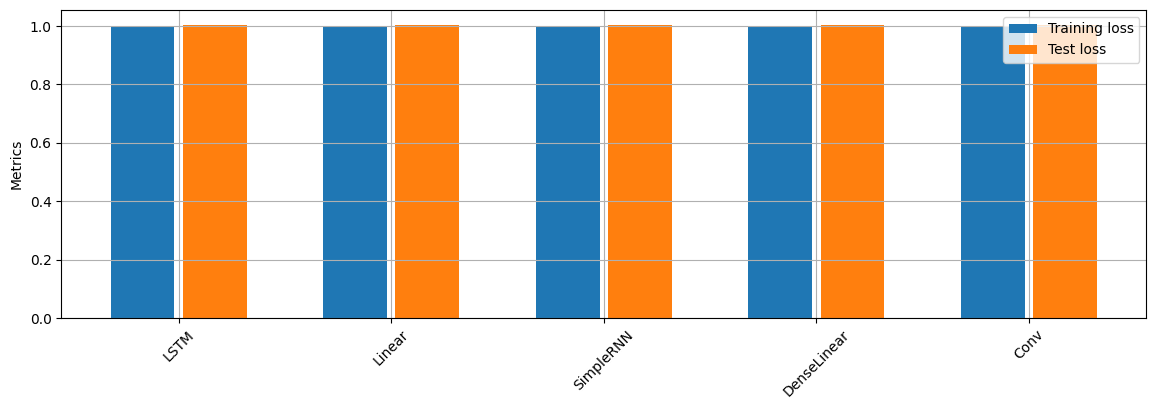

In [10]:
for i, model in enumerate(models):
    print(f"Now Compiling {i+1}/{len(models)} {model.name} ")
    #history = compile_fit(model, window_trn, window_tst, epochs=5, verbose=1)
    history = compile_fit(model, None, window_tst, epochs=5, verbose=1)
    IPython.display.clear_output()

# Plot graphs
#performance={}
performance = ts_plot_utils.plot_performance(models, window_trn100, window_tst100, performance=performance, reeval=1)

In [11]:
performance

{'LSTM': (0.9991540312767029, 1.0051445960998535),
 'Linear': (0.9991540312767029, 1.0051445960998535),
 'SimpleRNN': (0.9991540312767029, 1.0051445960998535),
 'DenseLinear': (0.9991540312767029, 1.0051445960998535),
 'Conv': (0.9991540312767029, 1.0051445960998535)}

### Predictions

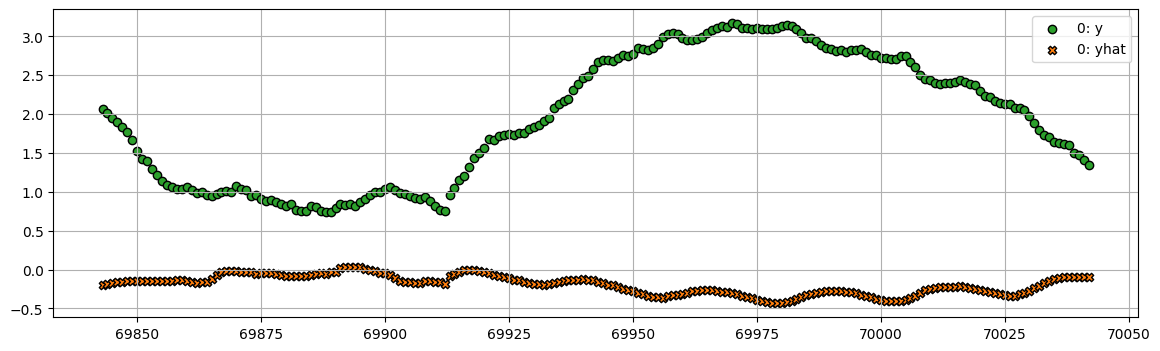

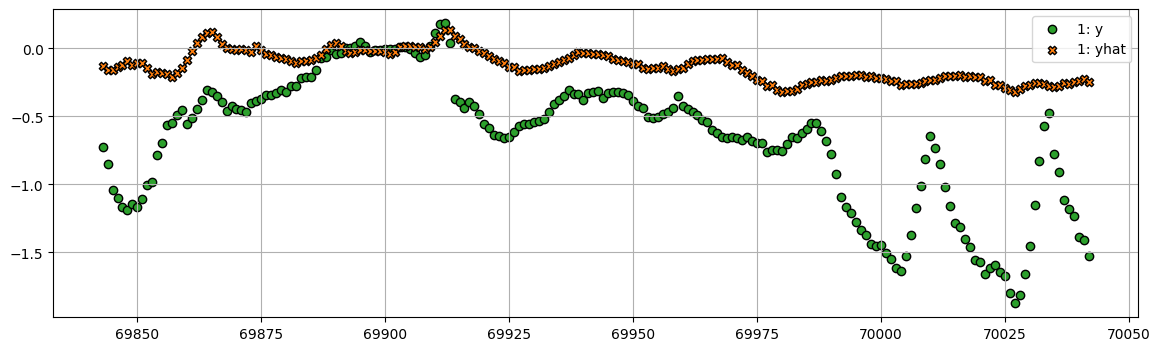

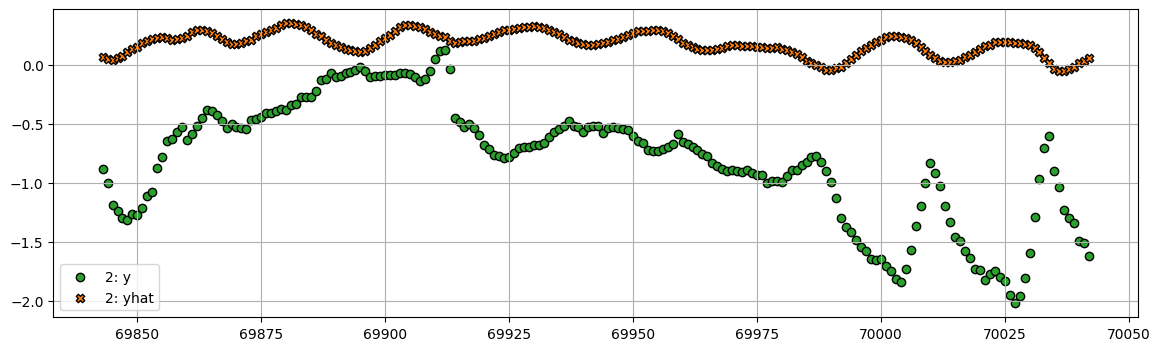

''

In [12]:
model = umodel
ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
                        plot_start=-200, df=None, scaler=None, label_slice=None)
;

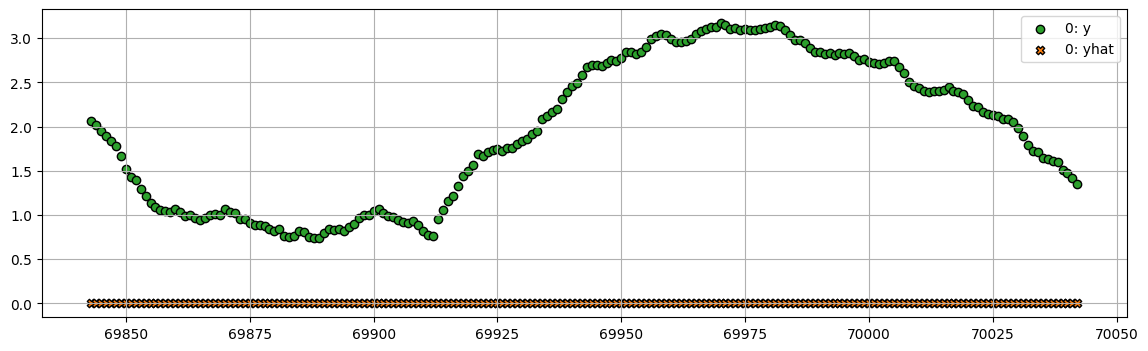

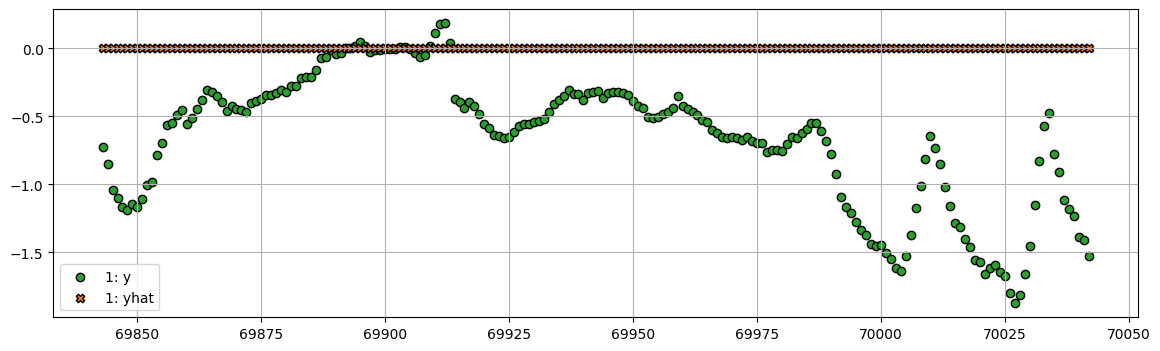

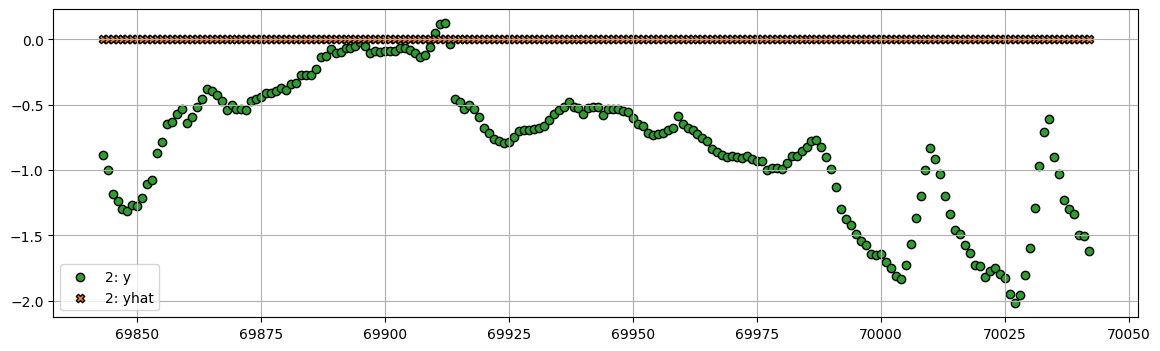

''

In [13]:
model = linear_model
ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
                        plot_start=-200, df=None, scaler=None, label_slice=None)
;

### The END